In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_design_matrix, plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
from nilearn import datasets
import glob
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/zeynepenkavi/Documents/RangelLab/DescribedVsLearned_fmri/analysis/03_level3')
from make_design_files import make_design_files

In [29]:
def get_filt_tval_img(reg, threshold=0.95):
    pos_pval_fn = '%s/rand_model1_%s_tfce_corrp_tstat1.nii.gz'%(reg, reg)
    neg_pval_fn = '%s/rand_model1_%s_tfce_corrp_tstat1.nii.gz'%(reg, 'neg_'+reg)
    tval_fn = '%s/rand_model1_%s_tstat1_tfce.nii.gz'%(reg, reg)
    
    pos_pval_img = os.path.join(level3_path, pos_pval_fn)
    neg_pval_img = os.path.join(level3_path, neg_pval_fn)
    tval_img = os.path.join(level3_path, tval_fn)
    
    pos_pval_img = nib.load(pos_pval_img)
    neg_pval_img = nib.load(neg_pval_img)
    tval_img = nib.load(tval_img)
    
    tval_data = tval_img.get_fdata()
    pos_pval_data = pos_pval_img.get_fdata()
    neg_pval_data = neg_pval_img.get_fdata()
    
    filt_tval_data = np.where(pos_pval_data > threshold, tval_data, np.where(neg_pval_data > threshold, tval_data, 0))
    filt_tval_img = nib.Nifti1Image(filt_tval_data.astype(np.float64), tval_img.affine)
    
    return filt_tval_img

def plot_filt_tval_img(reg, threshold=0.95, interactive=False):
    filt_tval_img = get_filt_tval_img(reg, threshold=threshold)
    if(len(np.unique(filt_tval_img.get_fdata())) == 1):
        print('Nothing survives correction for %s'%(reg))
    elif interactive:
        view = view_img(filt_tval_img, 
             draw_cross=False,
             title='%s'%(reg))
        
        return view
    else:
        print('Plotting tvalues filtered for corrected p values > 0.05')
        plot_stat_map(filt_tval_img, 
             draw_cross=False,
             title='%s'%(reg))

In [6]:
level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/model1'

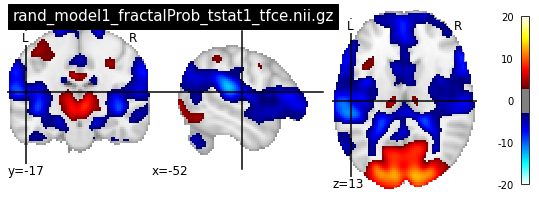

In [14]:
reg = 'fractalProb'
tval_fn = '%s/rand_model1_%s_tstat1_tfce.nii.gz'%(reg, reg)
tval_img = os.path.join(level3_path, tval_fn)
plot_stat_map(tval_img, threshold=3, title=os.path.basename(tval_img))

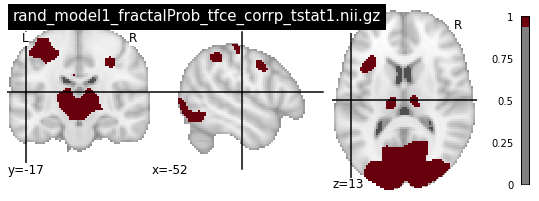

In [26]:
pval_fn = '%s/rand_model1_%s_tfce_corrp_tstat1.nii.gz'%(reg, reg)
pval_img = os.path.join(level3_path, pval_fn)
plot_stat_map(pval_img, title=os.path.basename(pval_img), cut_coords = (-52, -17, 13), threshold = 0.95, cmap="Reds")

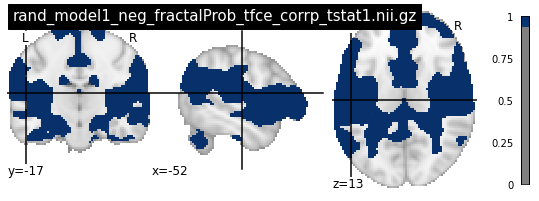

In [25]:
pval_fn = '%s/rand_model1_%s_tfce_corrp_tstat1.nii.gz'%(reg, 'neg_'+reg)
pval_img = os.path.join(level3_path, pval_fn)
plot_stat_map(pval_img, title=os.path.basename(pval_img),cut_coords = (-52, -17, 13), threshold = 0.95, cmap="Blues")

In [30]:
plot_filt_tval_img(reg)

AttributeError: 'str' object has no attribute 'affine'

# RT modeling difference

Pertains to cross, valChosen, valUnchosen, conflict, noconflict

# Event regressors

Change in activity when fractal probabilities are presented

Change in activity when stimuli are presented

Change in activity when reward is presented

# Parametric regressors

# Conflict vs no conflict

In [ ]:
tval_fn = '%s/rand_model1_%s_tstat1_tfce.nii.gz'%(reg, reg)
tval_img = os.path.join(level3_path, tval_fn)
plot_stat_map(tval_img, threshold=3, draw_cross=False)

# Slow vs fast learner

# Interactions with p(Fractal)

In [ ]:
Does processing of